In [1]:
import os
import sys

In [2]:
sys.path.append('..')

In [3]:
from tqdm.notebook import tqdm

In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from scipy import ndimage
from umap import UMAP

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as TF
from torch.utils.data import DataLoader

In [7]:
from mvc.data import SleepDataset, SleepDatasetImg, TwoDataset
from mvc.model import MC3, DPCFusionClassifier

In [8]:
# DATA_PATH_V1 = '/data/DataHub/SleepClassification/sleepedf39/sleepedf39/'
# DATA_PATH_V2 = '/data/DataHub/SleepClassification/sleepedf39/sleepedf39_img/'
DATA_PATH_V1 = '/data/DataHub/SleepClassification/isruc/isruc'
DATA_PATH_V2 = '/data/DataHub/SleepClassification/isruc/isruc_img'
LABEL2STR = {
    0: 'Wake',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    4: 'REM'
}

In [9]:
use_dropout = False
use_l2_norm = True
use_final_bn = True

In [ ]:
classifier = DPCFusionClassifier(first_network='r1d', second_network='r2d',
                                     first_channels=6, second_channels=18,
                                     hidden_channels=16, feature_dim=128, num_class=5,
                                     use_dropout=use_dropout, use_l2_norm=use_l2_norm, use_batch_norm=use_final_bn,
                                     device='cuda:0')
classifier.cuda('cuda:0')

In [11]:
# classifier.load_state_dict(torch.load('/data/XiaoQinfeng/work_dir/pytorch/MultiViewCo/cache/cosleep/sleepedf39_fold9/cosleep_first_run_9_iter_2.pth.tar'), strict=False)
classifier.load_state_dict(torch.load('/data/XiaoQinfeng/work_dir/pytorch/MultiViewCo/cache/cosleep/sleepedf39_fold9/cosleep_first_run_9_iter_2.pth.tar'), strict=False)

_IncompatibleKeys(missing_keys=['encoder.head.0.weight', 'encoder.head.1.weight', 'encoder.head.1.bias', 'encoder.head.1.running_mean', 'encoder.head.1.running_var', 'encoder.layer1.0.layers.0.weight', 'encoder.layer1.0.layers.1.weight', 'encoder.layer1.0.layers.1.bias', 'encoder.layer1.0.layers.1.running_mean', 'encoder.layer1.0.layers.1.running_var', 'encoder.layer1.0.layers.3.weight', 'encoder.layer1.0.layers.4.weight', 'encoder.layer1.0.layers.4.bias', 'encoder.layer1.0.layers.4.running_mean', 'encoder.layer1.0.layers.4.running_var', 'encoder.layer1.0.downsample.0.weight', 'encoder.layer1.0.downsample.1.weight', 'encoder.layer1.0.downsample.1.bias', 'encoder.layer1.0.downsample.1.running_mean', 'encoder.layer1.0.downsample.1.running_var', 'encoder.layer1.1.layers.0.weight', 'encoder.layer1.1.layers.1.weight', 'encoder.layer1.1.layers.1.bias', 'encoder.layer1.1.layers.1.running_mean', 'encoder.layer1.1.layers.1.running_var', 'encoder.layer1.1.layers.3.weight', 'encoder.layer1.1.laye

In [12]:
files = os.listdir(DATA_PATH_V1)
patients = []
for a_file in files:
    if a_file.endswith('.npz'):
        patients.append(a_file)

patients = sorted(patients)
patients = np.asarray(patients)

In [13]:
kf = KFold(n_splits=10)
for i, (train_index, test_index) in enumerate(kf.split(patients)):
    if i == 9:
        train_patients, test_patients = patients[train_index].tolist(), patients[test_index].tolist()
        break

In [14]:
transform = TF.Compose(
        [TF.Resize((64, 64)), TF.ToTensor()]
    )
test_dataset_v1 = SleepDataset(DATA_PATH_V1, 'sleepedf', 10, train_patients,
                               preprocessing='standard')
test_dataset_v2 = SleepDatasetImg(DATA_PATH_V2, 'sleepedf', 10, transform=transform,
                                  patients=train_patients)

::: LOADING IMG DATA :::: 100%|██████████| 36/36 [00:07<00:00,  5.06it/s]


In [15]:
encoder_q = classifier.encoder
encoder_k = classifier.sampler

In [16]:
dataset = TwoDataset(test_dataset_v1, test_dataset_v2)

In [17]:
data_loader = DataLoader(dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)

In [18]:
embeddings = []
labels = []
recordings = []

with torch.no_grad():
    for x1, y, x2, _ in tqdm(data_loader):
        x1, x2 = x1.cuda('cuda:0', non_blocking=True), x2.cuda('cuda:0', non_blocking=True)
        
        batch_size, num_epoch, *x1_shape = x1.shape
        x1 = x1.view(batch_size * num_epoch, *x1_shape)
        x2 = x2.view(batch_size * num_epoch, *x2.shape[2:])
        z = encoder_q(x1)
        z = F.normalize(z, p=2, dim=-1)
        embeddings.append(z.cpu().numpy())
        labels.append(y.view(-1).cpu().numpy())
        recordings.append(x1.cpu().numpy())

In [19]:
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)
recordings = np.concatenate(recordings, axis=0)

In [20]:
print(embeddings.shape)
print(labels.shape)

(35840, 128)
(35840,)


# Nearest Neighbor Retrieval

In [21]:
idx = [np.random.choice(np.arange(len(labels))[labels==i], size=1)[0] for i in range(5)]
print(idx)

[6011, 3196, 19754, 7489, 21840]


In [22]:
idx[0] = 13150
idx[1] = 14372
idx[2] = 8913
idx[3] = 7476
idx[4] = 22736

In [23]:
x = np.stack([embeddings[i] for i in idx], axis=0)

In [24]:
dis = []
for i in range(5):
    dis.append(np.sqrt(((embeddings - x[i].reshape(1, -1))**2).sum(axis=1)))
dis = np.stack(dis, axis=0)

In [25]:
retrieval_idx = [np.argsort(dis[i])[1:4].tolist() for i in range(5)]
retrieval_embs = [embeddings[i] for i in retrieval_idx]
retrieval_signals = [recordings[i, 0, :] for i in retrieval_idx]
retrieval_labels = [labels[i] for i in retrieval_idx]
print(retrieval_idx)
print(retrieval_labels)

[[12613, 30363, 9341], [970, 11737, 14379], [22894, 2502, 30602], [17483, 11280, 15911], [3536, 4355, 14299]]
[array([2, 0, 2]), array([0, 0, 0]), array([0, 0, 2]), array([4, 0, 2]), array([2, 2, 3])]


In [26]:
mat_dict = {}
mat_dict['ori'] = recordings[idx, 0, :]
for i in range(5):
    mat_dict[f'emb{i}'] = retrieval_signals[i]
    mat_dict[f'label{i}'] = retrieval_labels[i]
sio.savemat('../data/retrieval.mat', mat_dict)

<ipython-input-27-f9883f0e3ffd>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


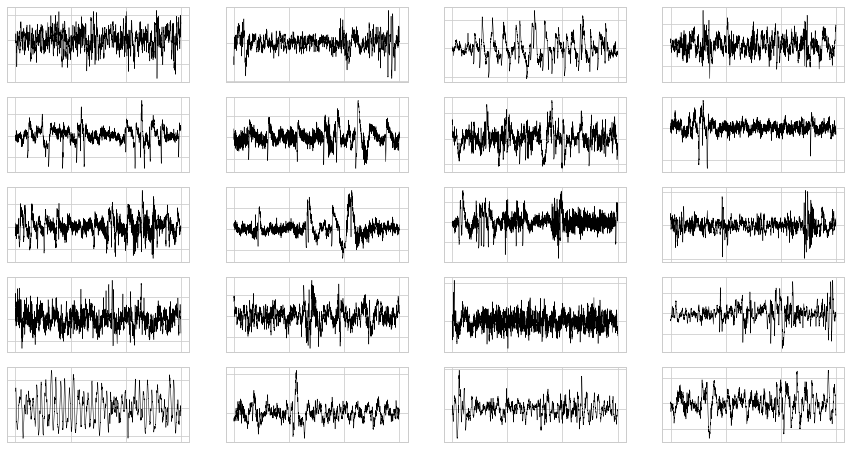

In [27]:
with plt.style.context(['seaborn-whitegrid']):
    fig, (*axes, ) = plt.subplots(figsize=(15,8), nrows=5, ncols=4)
    for i in range(5):
        axes[i][0].plot(recordings[idx[i]][0], color='k', linewidth=0.5)
        axes[i][0].set_xticklabels([])
        axes[i][0].set_yticklabels([])
        for j in range(3):
            axes[i][j+1].plot(recordings[retrieval_idx[i][j]][0], color='k', linewidth=0.5)
            axes[i][j+1].set_xticklabels([])
            axes[i][j+1].set_yticklabels([])
    fig.savefig('../data/retrieval.pdf')
    fig.show()

# Visualize Representations

In [95]:
n_samples = 5000

In [96]:
indices = np.random.choice(np.arange(len(embeddings)), size=n_samples, replace=False)
x = embeddings[indices]
y = labels[indices]
print(x.shape)

(5000, 128)


In [97]:
# proj_model = TSNE(n_components=2, init='pca', metric='cosine', n_jobs=8, random_state=2020)
proj_model = UMAP(n_components=2, init='random', metric='cosine', n_jobs=8, random_state=2020)

In [98]:
trans_data = proj_model.fit_transform(x)

In [99]:
print(trans_data)
print(trans_data.shape)

[[8.760995   5.8767786 ]
 [9.851214   6.33395   ]
 [2.9183397  0.4807857 ]
 ...
 [2.531027   2.127344  ]
 [2.7896156  0.81095487]
 [9.374418   5.7813816 ]]
(5000, 2)


In [100]:
print(np.min(trans_data[:, 0]))
print(np.max(trans_data[:, 0]))
print(np.min(trans_data[:, 1]))
print(np.max(trans_data[:, 1]))

-0.55181426
11.052077
0.30471882
9.255522


In [101]:
x_min = 3
x_max = 9
y_min = -1
y_max = 15
n_interval = 100
x_dis = (x_max - x_min) / n_interval
y_dis = (y_max - y_min) / n_interval
xx = np.linspace(x_min, x_max, n_interval)
yy = np.linspace(y_min, y_max, n_interval)
X, Y = np.meshgrid(xx, yy)

In [102]:
def density_func(x, y):
    selector = np.logical_and(np.logical_and(x <= trans_data[:, 0], trans_data[:, 0] < x + x_dis), 
                              np.logical_and(y <= trans_data[:, 1], trans_data[:, 1] < y + y_dis))
    res = np.count_nonzero(selector) / n_samples
    
    return res

In [103]:
def density(X, Y):
    x = X[0]
    y = Y[:, 0].reshape(-1)
    res = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            res[i, j] = density_func(x[i], y[j])
    return res.T*100

In [104]:
print(density(X, Y))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [105]:
print(ndimage.gaussian_filter(density(X, Y), sigma=1.5))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<ipython-input-106-4cae38422fd8>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


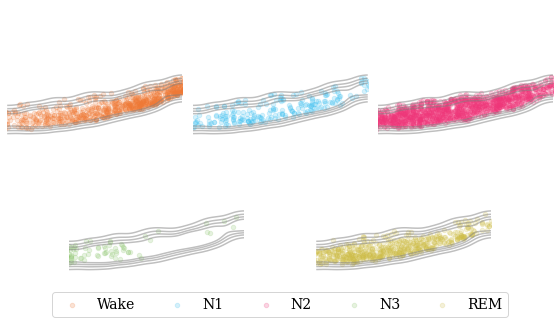

In [106]:
colors = ['#EE7733', '#33BBEE', '#EE3377', '#86C166', '#CCBB44', "#0d49fb"]
grid = plt.GridSpec(2, 11, wspace=0.2, hspace=0)
fig = plt.figure(figsize=(12, 5))

for i in range(5):
    if i == 0:
        ax = plt.subplot(grid[0, 1:4])
    elif i == 1:
        ax = plt.subplot(grid[0, 4:7])
    elif i == 2:
        ax = plt.subplot(grid[0, 7:10])
    elif i == 3:
        ax = plt.subplot(grid[1, 2:5])
    else:
        ax = plt.subplot(grid[1, 6:9])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
#     [0.006, 0.012, 0.018, 0.024]
    c = ax.contour(X, Y, ndimage.gaussian_filter(density(X, Y), sigma=4), 
                   levels=[0.006, 0.012, 0.018, 0.024], 
                   colors='gray', linestyles='-', linewidths=1.5, alpha=0.5)
#     ax.clabel(c, inline=False)
    ax.scatter(trans_data[y==i, 0], trans_data[y==i, 1], label=LABEL2STR[i], alpha=0.2, s=20, c=colors[i])
    ax.axis('off')
# fig.suptitle('Visualization', fontsize=16)
fig.legend(loc='lower center', ncol=5, prop={'family': 'serif', 'size': 14})
fig.savefig('../data/embeddings.pdf')
fig.show()